# 4.2. Concise Implementation of Multilayer Perceptron

이번 실습은 ch3에서 다루었던 fashion-mnist dataset을 통한 softmax regression의 예제에서 사용하는 model만 MLP로 바꾸어 봅니다. 차이는 다음과 같은 두 가지 뿐입니다.
1. hidden layer의 추가 
2. nonliear activation function의 추가

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

colab을 사용하는 경우에는 google drive를 mount하도록 합니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root = '/content/drive/My Drive/hufs'

## Getting the Dataset

fasion-mnist dataset을 가져오는 과정으로 ch3에서 구글드라이브에 다운르도를 한 경우에는 다시 다운로드를 진행하지 않아도 됩니다.

In [0]:
pil2tensor = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root, train=True, transform=pil2tensor, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root, train=False, transform=pil2tensor, target_transform=None, download=True)
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

## The Model, Loss, Data_loader and parameters
model을 선언하는 부분을 따로 분리한 것을 제외하면 ch3에서의 실습과 완전히 동일합니다.

In [0]:
# setting hyper-parameters
batch_size = 256
learning_rate = 0.5
num_epochs = 30
num_workers = 0

# defining data_iter, linreg. model, loss, sgd
train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

## shallow -> deep
- ch3에서의 softmax regression은 28*28개의 feature를 input으로 받아 10개의 number를 출력하도록 linear model을 구성하였습니다.
- ch4의 MLP예제에서는 같은 input이 256개의 출력을 가지도록 linear model을 먼저 구성합니다.
- 256개의 출력에 nonlinear activation function ReLU를 적용시킨 후에, 다시 10개의 number를 출력하도록 linear model을 구성합니다.
- PyTorch에서는 nn.Sequential()을 이용하여 순차적으로 적용하는 model을 간단하게 구성할 수 있습니다.

In [6]:
# defining model
net = nn.Sequential(
    nn.Linear(28*28,256),
    nn.ReLU(),
    nn.Linear(256,10)
    )

# parameter initialization
torch.nn.init.normal_(net[0].weight,std=0.01)
torch.nn.init.normal_(net[2].weight,std=0.01)

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

# display model
net

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)

## Model Training
model을 훈련하면서 train loss, train accuracy, test accuracy를 관찰합니다.
바로 위의 cell의 hyperparameter들을 바꿔가면서 결과를 비교해 봅니다.

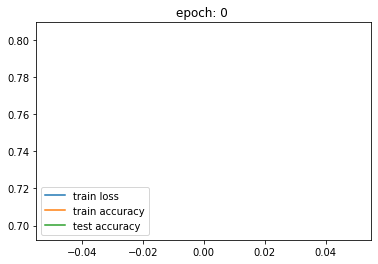

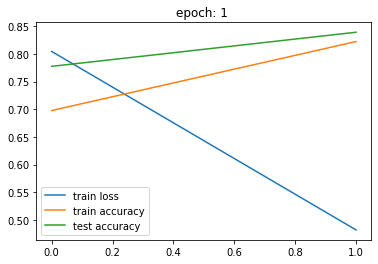

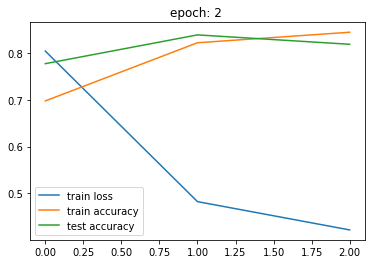

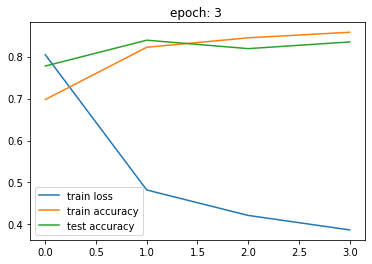

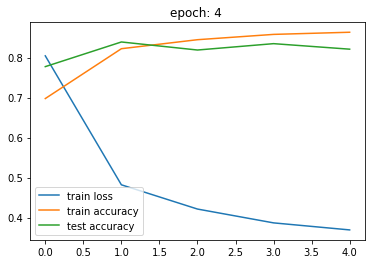

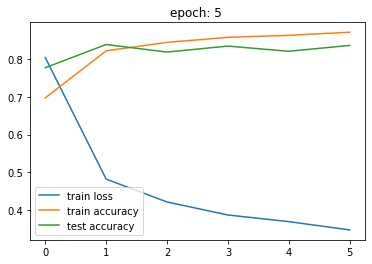

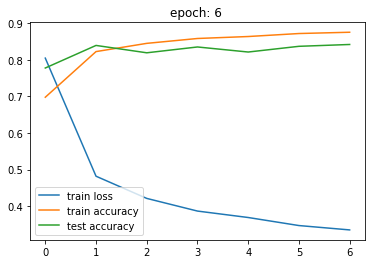

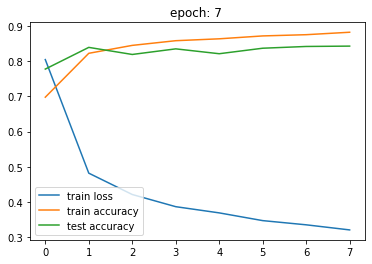

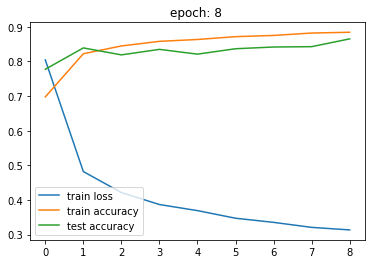

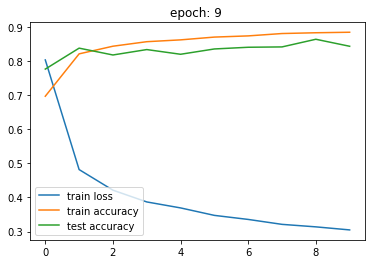

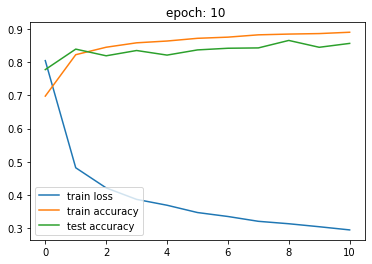

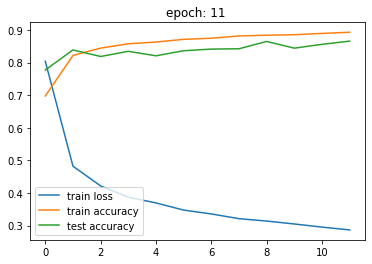

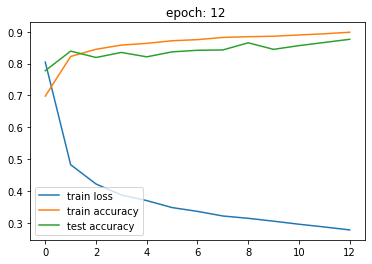

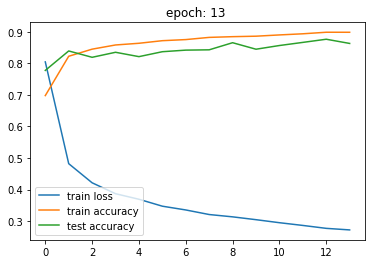

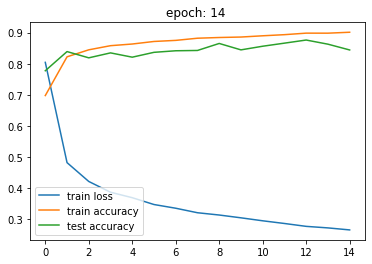

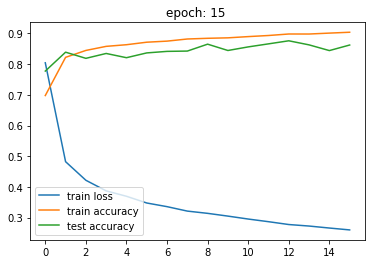

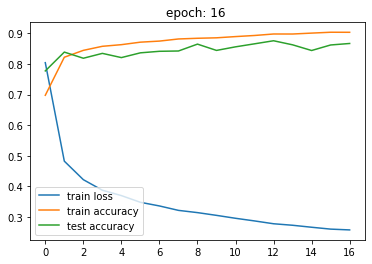

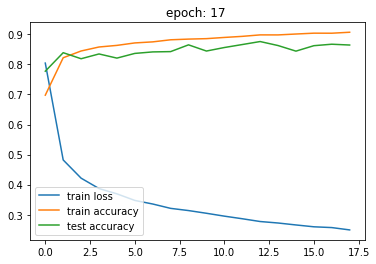

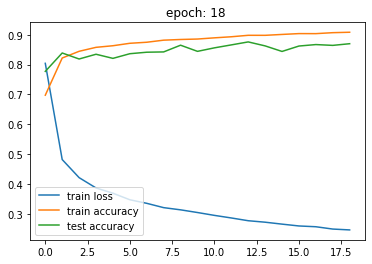

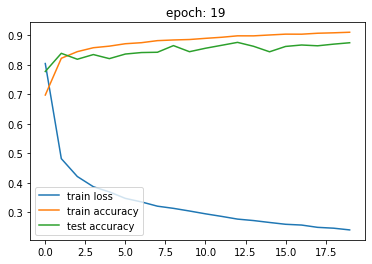

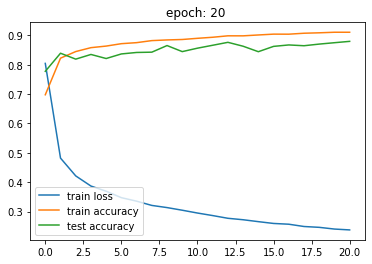

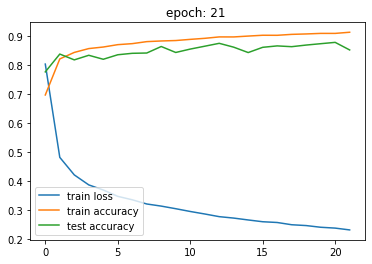

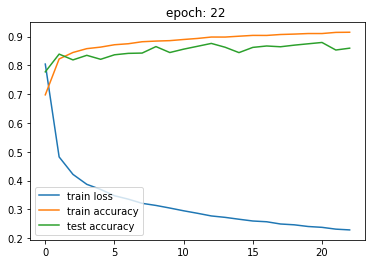

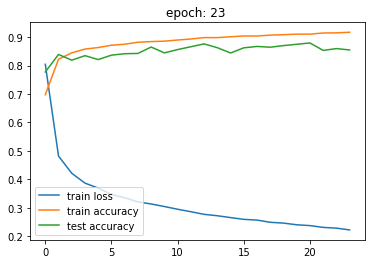

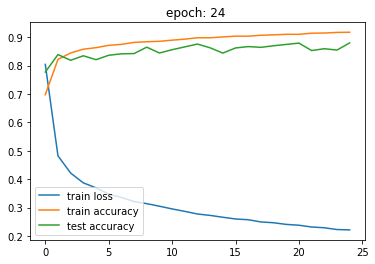

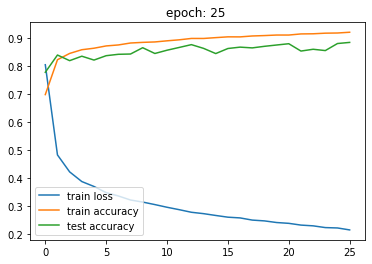

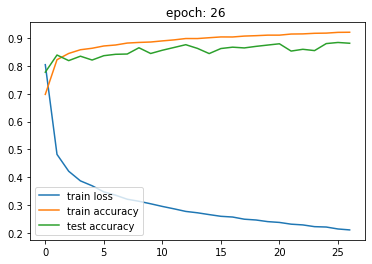

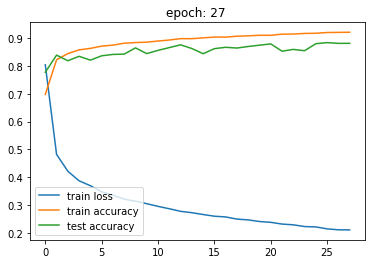

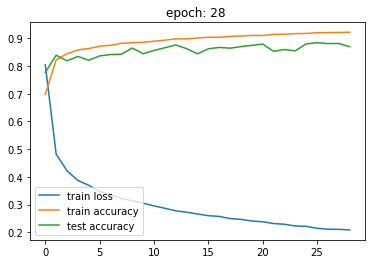

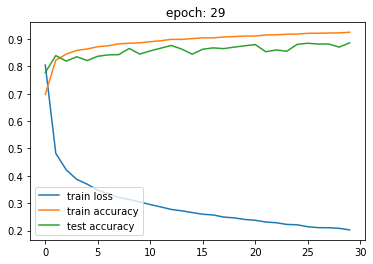

In [7]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_test = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X=X.view(-1,784)
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.detach().numpy()/i)
  accs_train = np.append(accs_train,correct/60000.)

  correct = 0
  for X,y in test_iter:
    y_hat = net(X.view(-1,784))
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_test = np.append(accs_test,correct/10000.)

  plt.plot(loss_train,label='train loss')
  plt.plot(accs_train,label='train accuracy')
  plt.plot(accs_test,label='test accuracy')
  plt.legend(loc='lower left')
  plt.title('epoch: %d '%(epoch))
  plt.pause(.0001)



## Prediction

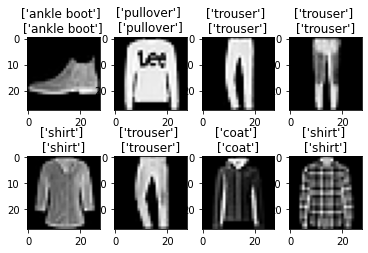

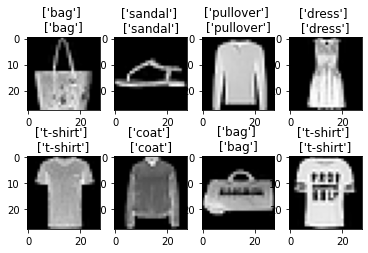

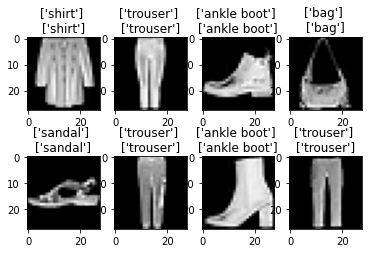

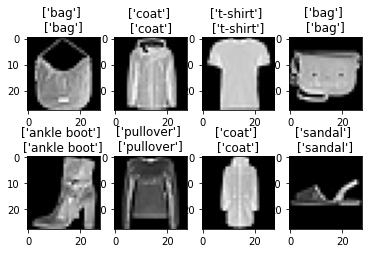

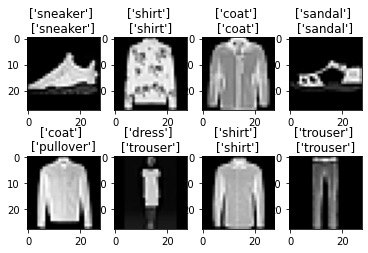

In [8]:
i = 0
for X,y in test_iter:
  i=i+1
  y_hat = net(X.view(-1,784))    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.subplot(241+n)
    plt.imshow(X[n].squeeze(),cmap='gray')
    plt.title('%s \n%s'%(get_fashion_mnist_labels([y[n]]),get_fashion_mnist_labels([y_hat[n]])))
  plt.pause(.0001)
  if i>4:
     break

## Softmax
학습된 model에 test set의 데이터 중 하나를 가져와서 예측값을 얻고 그 값들을 살펴봅시다.

y1 = 
 tensor([[-0.8838, -3.7414,  5.6074,  0.9154,  8.6217, -6.7175,  8.3596, -4.7261,
         -1.8833, -5.7765]], grad_fn=<AddmmBackward>)


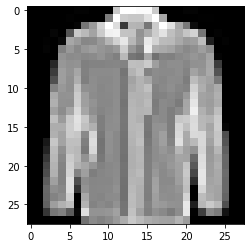

In [9]:
X1 = X[2]
X1.shape
y1 = net(X1.view(-1,784))
print('y1 = \n',y1)
plt.imshow(X1.squeeze(),cmap='gray')

fully connected layer의 output은 probability의 형태가 아닙니다. 우리는 softmax를 통해 output을 probability의 형태로 출력할 수 있습니다.

In [10]:
y1_softmax = y1.softmax(dim=1)
print('y1_softmax = \n',y1_softmax)

print('\nsum of y1_softmax = \n',torch.sum(y1_softmax))

print('\n 100 x y1_softmax = \n',(100*y1_softmax).long())


y1_softmax = 
 tensor([[4.0922e-05, 2.3491e-06, 2.6979e-02, 2.4737e-04, 5.4973e-01, 1.1978e-07,
         4.2299e-01, 8.7755e-07, 1.5062e-05, 3.0695e-07]],
       grad_fn=<SoftmaxBackward>)

sum of y1_softmax = 
 tensor(1.0000, grad_fn=<SumBackward0>)

 100 x y1_softmax = 
 tensor([[ 0,  0,  2,  0, 54,  0, 42,  0,  0,  0]])


우리는 예측결과를 다음과 같이 확률과 함께 출력해 줄 수 있습니다.

In [11]:
print('predicted: %s with probability %f'%(get_fashion_mnist_labels([y1_softmax.argmax(dim=1)]), y1_softmax.max()))

predicted: ['coat'] with probability 0.549728
